In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import matplotlib.pyplot as plt

# Callbacks
## Callbacks as GUI events

In [3]:
import ipywidgets as widgets

In [8]:
def f(o): #throws error if no argument is given here
    print('hi')

In [9]:
w = widgets.Button(description='Click me')

In [10]:
w

Button(description='Click me', style=ButtonStyle())

hi


In [11]:
w.on_click(f) # this says that call back to f, when something happens (click)

Note that just `f` is passed as an argument, not `f()`

### Create a callback

In [10]:
from time import sleep

In [11]:
def slow_calculation():
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
    return res

In [12]:
slow_calculation()

30

In [13]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
        if cb:
            cb(i)
    return res

In [14]:
def show_progress(epoch):
    print(f'Finished epoch {epoch}!')

In [15]:
slow_calculation(show_progress)

Finished epoch 0!
Finished epoch 1!
Finished epoch 2!
Finished epoch 3!
Finished epoch 4!


30

## Lambdas and partials

In [16]:
slow_calculation(lambda x: print(f'Finished epoch {x}'))

Finished epoch 0
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4


30

In [17]:
def show_progress(exclamation, epoch):
    print(f'{exclamation}! Finished epoch {epoch}!')

In [18]:
slow_calculation(show_progress) # will give an error because it should take only one argument

TypeError: show_progress() missing 1 required positional argument: 'epoch'

In [19]:
# convert to only one argument
slow_calculation(lambda x: show_progress('hello', x))

hello! Finished epoch 0!
hello! Finished epoch 1!
hello! Finished epoch 2!
hello! Finished epoch 3!
hello! Finished epoch 4!


30

In [20]:
def make_show_progress(exclamation):
    _inner = lambda epoch: print(f'{exclamation}! done with epoch {epoch}!')
    return _inner

In [21]:
slow_calculation(make_show_progress('wow'))

wow! done with epoch 0!
wow! done with epoch 1!
wow! done with epoch 2!
wow! done with epoch 3!
wow! done with epoch 4!


30

In [22]:
def make_show_progress(exclamation):
    def _inner(epoch):
        print(f'{exclamation}! done with epoch {epoch}!')
    return _inner

This concept where a function uses something from the external context every time is called a closure

In [23]:
slow_calculation(make_show_progress('amaze'))

amaze! done with epoch 0!
amaze! done with epoch 1!
amaze! done with epoch 2!
amaze! done with epoch 3!
amaze! done with epoch 4!


30

In [24]:
f2 = make_show_progress('terrific')

In [25]:
slow_calculation(f2)

terrific! done with epoch 0!
terrific! done with epoch 1!
terrific! done with epoch 2!
terrific! done with epoch 3!
terrific! done with epoch 4!


30

In [27]:
from functools import partial

In [29]:
f2 = partial(show_progress, 'this is ok')

In [30]:
f2 # try shift+tab here - takes only one argument which is the epoch

functools.partial(<function show_progress at 0x7f4bee5518c0>, 'this is ok')

In [31]:
slow_calculation(f2)

this is ok! Finished epoch 0!
this is ok! Finished epoch 1!
this is ok! Finished epoch 2!
this is ok! Finished epoch 3!
this is ok! Finished epoch 4!


30

## Callbacks as callable classes

In [32]:
class ProgressShowingCallback():
    def __init__(self, exclamation='awesome'):
        self.exclamation = exclamation
    def __call__(self, epoch):
        print(f'{self.exclamation}! finished epoch {epoch}!')

In [33]:
cb = ProgressShowingCallback()

In [34]:
slow_calculation(cb)

awesome! finished epoch 0!
awesome! finished epoch 1!
awesome! finished epoch 2!
awesome! finished epoch 3!
awesome! finished epoch 4!


30

In [35]:
cb = ProgressShowingCallback('hi')

In [36]:
slow_calculation(cb)

hi! finished epoch 0!
hi! finished epoch 1!
hi! finished epoch 2!
hi! finished epoch 3!
hi! finished epoch 4!


30

In [37]:
cb('ssup')

hi! finished epoch ssup!


## Multiple callback funcs; `*args` and `**kwargs`

In [38]:
def f(*args, **kwargs):
    print(f'args: {args}; kwargs: {kwargs}')

In [39]:
f(3, 'a', thing='hi')

args: (3, 'a'); kwargs: {'thing': 'hi'}


In [40]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb:
            cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb:
            cb.after_calc(i, val=res)
    return res

In [41]:
class PrintStepCallback():
    def __init__(self):
        pass
    def before_calc(self, *args, **kwargs):
        print(f'About to start')
    def after_calc(self, *args, **kwargs):
        print(f'Done step')

In [42]:
slow_calculation(PrintStepCallback())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

In [43]:
class PrintStatusCallback():
    def __init__(self):
        pass
    def before_calc(self, epoch, **kwargs):
        print(f'About to start: {epoch}')
    def after_calc(self, epoch, val, **kwargs):
        print(f'After {epoch}: {val}')

In [44]:
slow_calculation(PrintStatusCallback())

About to start: 0
After 0: 0
About to start: 1
After 1: 1
About to start: 2
After 2: 5
About to start: 3
After 3: 14
About to start: 4
After 4: 30


30

## Modifying behaviour

In [45]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb and hasattr(cb, 'before_calc'):
            cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb and hasattr(cb, 'after_calc'):
            if cb.after_calc(i, res):
                print('stopping early')
                break
    return res

In [46]:
class PrintAfterCallback():
    def after_calc(self, epoch, val):
        print(f'After {epoch}:{val}')
        if val>10:
            return True

In [47]:
slow_calculation(PrintAfterCallback())

After 0:0
After 1:1
After 2:5
After 3:14
stopping early


14

In [72]:
class SlowCalculator():
    def __init__(self, cb=None):
        self.cb, self.res = cb, 0
        
    def callback(self, cb_name, *args):
        if not self.cb:
            return
        cb = getattr(self.cb, cb_name, None)
        if cb:
            return cb(self, *args) #sending self here - self is entire SlowCalculator object
        
    def calc(self):
        for i in range(5):
            self.callback('before_calc', i)
            self.res += i*i
            sleep(1)
            if self.callback('after_calc', i):
                print('stopping early')
                break

In [76]:
class ModifyingCallback():
    def after_calc(self, calc, epoch):
        print(f'After {epoch}: {calc.res}')
        if calc.res>20:
            return True
        if calc.res<3:
            calc.res = calc.res*2

In [77]:
calculator = SlowCalculator(ModifyingCallback())

In [78]:
calculator.calc()
calculator.res

After 0: 0
After 1: 1
After 2: 6
After 3: 15
After 4: 31
stopping early


31

this can also be done using `__call__()` instead of having the `callback()` function like in `Runner` in previous lesson. This is how:

In [79]:
class SlowCalculator():
    def __init__(self, cb=None):
        self.cb, self.res = cb, 0
        
    def __call__(self, cb_name, *args):
        if not self.cb:
            return
        cb = getattr(self.cb, cb_name, None)
        if cb:
            return cb(self, *args) #sending self here - self is entire SlowCalculator object
        
    def calc(self):
        for i in range(5):
            self('before_calc', i)
            self.res += i*i
            sleep(1)
            if self('after_calc', i):
                print('stopping early')
                break

In [80]:
calculator = SlowCalculator(ModifyingCallback())

In [81]:
calculator.calc()
calculator.res

After 0: 0
After 1: 1
After 2: 6
After 3: 15
After 4: 31
stopping early


31

`__dunder__` thingies

In [82]:
class SloppyAdder():
    def __init__(self, o):
        self.o = o
    def __add__(self, b):
        return SloppyAdder(self.o + b.o + 0.01)
    def __repr__(self):
        return str(self.o)

In [83]:
a = SloppyAdder(1)
b = SloppyAdder(2)
a+b

3.01

Methods to know about:
- `__getitem__`
- `__getattr__`
- `__setattr__`
- `__del__`
- `__init__`
- `__new__`
- `__enter__`
- `__exit__`
- `__len__`
- `__repr__`
- `__str__`

# Variance and stuff

## Variance

Variance is the average of how far away each data point is from the mean

In [91]:
t = torch.tensor([1., 2, 4, 18])

In [92]:
t

tensor([ 1.,  2.,  4., 18.])

In [93]:
m = t.mean(); m

tensor(6.2500)

In [94]:
(t-m).mean()

tensor(0.)

we should handle positive and negative distances

In [98]:
(t-m).pow(2).mean() #variance

tensor(47.1875)

In [99]:
(t-m).abs().mean() # mean absolute deviation

tensor(5.8750)

In [100]:
# what if we undo the square that we did in the first one
(t-m).pow(2).mean().sqrt() # standard deviation

tensor(6.8693)

standard deviation is more sensitive to outliers than mean absolute deviation, because outliers blow up the difference. std dev is larger here than the mean abs dev. We can choose the metric according to the sensitivity that we want.  
absolute value measures can often work better than squared measures. do check them always

In [101]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.1875), tensor(47.1875))

In [104]:
# advised to use the latter one because it's computationally more efficient

## Covariance and correlation

In [102]:
t

tensor([ 1.,  2.,  4., 18.])

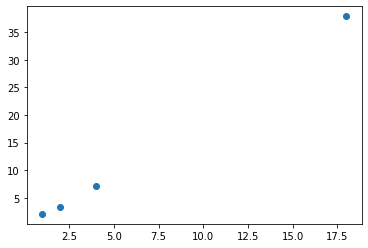

In [103]:
# `u` is twice `t`, plus a little bit of noise
u = t*2
u *= torch.randn_like(t)/10 + 0.95

plt.scatter(t, u)

In [108]:
prod = (t - t.mean()) * (u - u.mean()); prod

tensor([ 55.0865,  39.6807,  12.2209, 296.8143])

In [109]:
prod.mean()

tensor(100.9506)

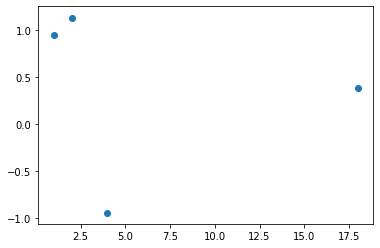

In [110]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [111]:
((t-t.mean()) * (v - v.mean())).mean()

tensor(-0.7904)

In [112]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(-0.7904)

In [114]:
cov / (t.std() * v.std()) # this is correlation - pearson correlation coefficient

tensor(-0.1063)

### Softmax

In [115]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()